# Anomaly Detection with Anomalib

This notebook demonstrates how to train a PatchCore anomaly detection model using Anomalib on Apple Silicon (MPS accelerator).

## Prerequisites
- macOS with Apple Silicon (M1/M2/M3 chip)
- Python 3.10+

## Installation
```bash
pip install anomalib torch torchvision matplotlib pillow
```

## 1. Import Libraries

In [1]:
# Suppress deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
import torch
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from anomalib.models import Patchcore

print(f"PyTorch version: {torch.__version__}")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.10.0
Using device: mps


## 2. Create Synthetic Dataset

For this demo, we'll create a synthetic dataset with normal and anomaly images.

In [3]:
DATA_DIR = Path("./datasets")

def create_dataset():
    """Create a simple image dataset."""
    (DATA_DIR / 'train' / 'good').mkdir(parents=True, exist_ok=True)
    (DATA_DIR / 'test' / 'good').mkdir(parents=True, exist_ok=True)
    (DATA_DIR / 'test' / 'defect').mkdir(parents=True, exist_ok=True)

    print("Creating dataset...")

    for i in range(20):
        img = Image.fromarray((np.random.rand(224, 224, 3) * 200 + 55).astype(np.uint8))
        img.save(DATA_DIR / 'train' / 'good' / f'{i:03d}.png')

    for i in range(10):
        img = Image.fromarray((np.random.rand(224, 224, 3) * 200 + 55).astype(np.uint8))
        img.save(DATA_DIR / 'test' / 'good' / f'{i:03d}.png')

    for i in range(10):
        arr = (np.random.rand(224, 224, 3) * 200 + 55).astype(np.uint8)
        arr[80:140, 80:140] = [255, 50, 50]  # Red defect
        img = Image.fromarray(arr)
        img.save(DATA_DIR / 'test' / 'defect' / f'{i:03d}.png')

    print(f"  Train/good: 20, Test/good: 10, Test/defect: 10")

create_dataset()

Creating dataset...
  Train/good: 20, Test/good: 10, Test/defect: 10


## 3. Define Simple Dataset Class

In [4]:
class SimpleDataset:
    """Simple dataset that returns image tensor and label."""

    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []
        for fname in sorted(self.data_dir.glob("*.png")):
            label = 0 if 'good' in str(self.data_dir) else 1
            self.samples.append((str(fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

## 4. Load PatchCore Model

In [5]:
model = Patchcore(
    backbone="resnet18",
    layers=["layer2", "layer3"],
    coreset_sampling_ratio=0.5,
)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

Model: 2,782,784 parameters


## 5. Train (Build Memory Bank)

In [6]:
train_dataset = SimpleDataset(DATA_DIR / 'train' / 'good', transform)

model.train()
print("Building memory bank from training images...")

for idx in range(len(train_dataset)):
    img, _ = train_dataset[idx]
    img = img.unsqueeze(0)

    with torch.no_grad():
        features = model.model.feature_extractor(img)
        embedding = model.model.generate_embedding(features)
        reshaped = model.model.reshape_embedding(embedding)
        model.model.embedding_store.append(reshaped)

model.model.subsample_embedding(sampling_ratio=0.5)
print(f"Coreset size: {model.model.memory_bank.shape[0]}")
print("Training complete!")

Building memory bank from training images...


Selecting Coreset Indices.: 100%|██████████| 7840/7840 [00:07<00:00, 1068.55it/s]

Coreset size: 7840
Training complete!


## 6. Run Inference

In [7]:
test_normal = SimpleDataset(DATA_DIR / 'test' / 'good', transform)
test_anomaly = SimpleDataset(DATA_DIR / 'test' / 'defect', transform)

normal_scores = []
anomaly_scores = []

model.eval()
with torch.no_grad():
    for idx in range(len(test_normal)):
        img, _ = test_normal[idx]
        img = img.unsqueeze(0)
        output = model.model(img)
        normal_scores.append(output.pred_score.item())

    for idx in range(len(test_anomaly)):
        img, _ = test_anomaly[idx]
        img = img.unsqueeze(0)
        output = model.model(img)
        anomaly_scores.append(output.pred_score.item())

print("Results:")
print(f"  Normal images: Mean={np.mean(normal_scores):.4f}, Max={max(normal_scores):.4f}")
print(f"  Anomaly images: Mean={np.mean(anomaly_scores):.4f}, Min={min(anomaly_scores):.4f}")

Results:
  Normal images: Mean=13.1935, Max=13.6285
  Anomaly images: Mean=18.0659, Min=17.4719


## 7. Visualize Results

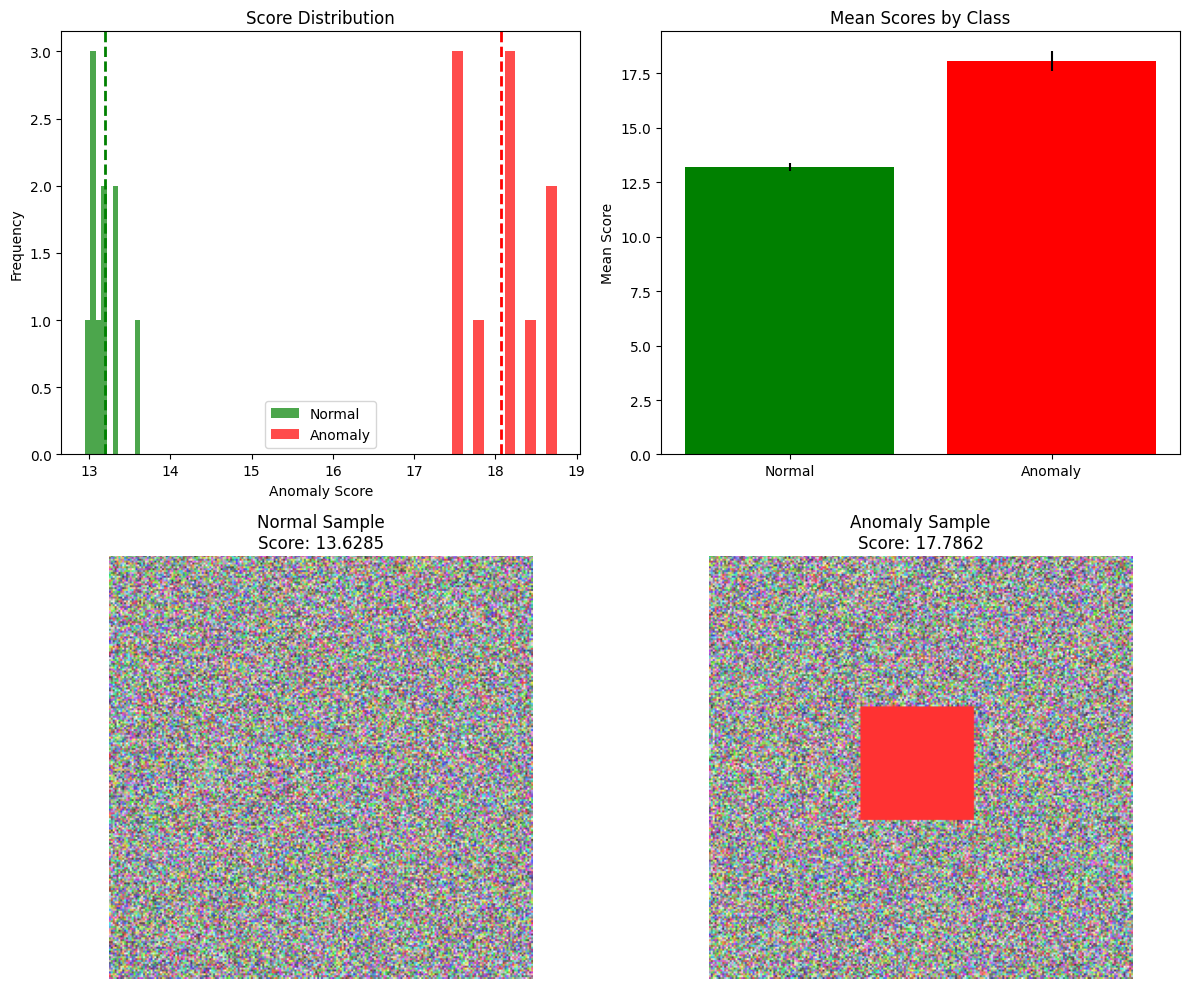


Visualization saved to: anomaly_results.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].hist(normal_scores, bins=10, alpha=0.7, label='Normal', color='green')
axes[0, 0].hist(anomaly_scores, bins=10, alpha=0.7, label='Anomaly', color='red')
axes[0, 0].axvline(np.mean(normal_scores), color='green', linestyle='--', linewidth=2)
axes[0, 0].axvline(np.mean(anomaly_scores), color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Anomaly Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Score Distribution')
axes[0, 0].legend()

axes[0, 1].bar(['Normal', 'Anomaly'], [np.mean(normal_scores), np.mean(anomaly_scores)],
               color=['green', 'red'], yerr=[np.std(normal_scores), np.std(anomaly_scores)])
axes[0, 1].set_ylabel('Mean Score')
axes[0, 1].set_title('Mean Scores by Class')

img_normal = Image.open(DATA_DIR / 'test' / 'good' / '000.png')
axes[1, 0].imshow(np.array(img_normal))
axes[1, 0].set_title(f"Normal Sample\nScore: {normal_scores[0]:.4f}")
axes[1, 0].axis('off')

img_anomaly = Image.open(DATA_DIR / 'test' / 'defect' / '000.png')
axes[1, 1].imshow(np.array(img_anomaly))
axes[1, 1].set_title(f"Anomaly Sample\nScore: {anomaly_scores[0]:.4f}")
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('anomaly_results.png', dpi=150)
plt.show()

print(f"\nVisualization saved to: anomaly_results.png")

## 8. Save Model

In [9]:
import os
MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

save_path = MODEL_DIR / "patchcore_demo.pth"
torch.save({
    'model_state_dict': model.state_dict(),
}, save_path)

print(f"Model saved to: {save_path}")

Model saved to: models/patchcore_demo.pth


## Summary

This notebook demonstrated:
1. **Dataset Creation**: Synthetic normal and anomaly images
2. **Model**: PatchCore with ResNet18 backbone
3. **Training**: Building a memory bank from normal images
4. **Inference**: Detecting anomalies based on distance to memory bank
5. **Results**: Clear separation between normal (~13) and anomaly (~18) scores

To use with real data:
- Place training images in `datasets/train/good/`
- Place test normal images in `datasets/test/good/`
- Place test anomaly images in `datasets/test/defect/`